# Stock Price Forecasting with Distilled-BERT & Stacked-LSTM

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 27 01:36:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [103]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import re
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
import urllib.request as req
import urllib.parse
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import transformers
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast
from transformers import TFAutoModelForSequenceClassification
from transformers import TFDistilBertForSequenceClassification
import datasets
import keras
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

# Load NASDAQ company list data to get the ticker symbols
nsdq_df = pd.read_csv("nsdq_df.csv")
symbols = list(nsdq_df["Symbol"])

## 1. News Headlines Crawling
* News Source: www.benzinga.com

In [172]:
# Clean time data of the parsed headlines
def time_clean(time): 
    regex = re.compile("(,)|(\s+\|\s\d+)")
    time = regex.sub('', time)
    time = datetime.strptime(time, '%Y %b %d %H:%M%p').date()
    return time

In [173]:
# Scraping news headlines with corresponding keywords and posted time
def scraping():
    
    df = {"time":[], "keywords":[], "headers":[]}
    base_url = "https://www.benzinga.com/news?page="
    symbol_list=[] # for symbol output at the end
    proc = 0 # for progress checking
    
    # Benzinga news section consists of 15 articles in each page 
    pages = {'init_page':input("Initial Page:"), 
            'last_page':input("Last Page:")}

                            # Parse data from each page of the website
    for page in range(int(pages['init_page']), int(pages['last_page'])+1): 
        url = base_url + str(page)
        html = req.urlopen(url)
        soup = BeautifulSoup(html, "html.parser")
        ul = soup.find_all("ul")

        ul_index=11
        li = ul[ul_index].find_all("li")
        for L in range(len(li)-1):
            a = li[L].find_all("a")
            # keywords (only symbols) can be plural
            wordList = [] 
            for A in range(int(len(a))-1):
                if A < len(a)-3:
                    word = a[A].text.strip()
                    # take only data whose keywords contain ticker symbols listed in NASDAQ
                    if word in symbols: 
                        wordList.append(word)
                else: 
                    if len(wordList) > 0:
                        header = a[A].text.strip()
                        span = li[L].find("span", {"class" : "date"})
                        time = span.text.strip()
                        time = time_clean(time)
                    else:
                        header = np.nan
                        time = np.nan
                    
            df["time"].append(time)   
            df["keywords"].append(wordList)
            df["headers"].append(header)
        
        proc += 1
        print("process: ", proc,"/",int(pages['last_page'])-int(pages['init_page']))
    
    news_data = pd.DataFrame(df).dropna().reset_index(drop=True)
    
    for row in range(len(news_data)):
        for symbol in news_data.keywords[row]:
            symbol_list.append(symbol)
            
    print('\n---------------\nTop10 Items:\n') 
    print(pd.DataFrame(Counter(symbol_list).most_common(10), columns = ["Symbols","Frequency"]))
    
    return news_data, symbol_list

In [174]:
tic = time.time()

news_data, symbol_list = scraping()

toc = time.time() - tic
print(' crawling completed in %.2f s.' % (toc))

Initial Page:1
Last Page:785
process:  1 / 784
process:  2 / 784
process:  3 / 784
process:  4 / 784
process:  5 / 784
process:  6 / 784
process:  7 / 784
process:  8 / 784
process:  9 / 784
process:  10 / 784
process:  11 / 784
process:  12 / 784
process:  13 / 784
process:  14 / 784
process:  15 / 784
process:  16 / 784
process:  17 / 784
process:  18 / 784
process:  19 / 784
process:  20 / 784
process:  21 / 784
process:  22 / 784
process:  23 / 784
process:  24 / 784
process:  25 / 784
process:  26 / 784
process:  27 / 784
process:  28 / 784
process:  29 / 784
process:  30 / 784
process:  31 / 784
process:  32 / 784
process:  33 / 784
process:  34 / 784
process:  35 / 784
process:  36 / 784
process:  37 / 784
process:  38 / 784
process:  39 / 784
process:  40 / 784
process:  41 / 784
process:  42 / 784
process:  43 / 784
process:  44 / 784
process:  45 / 784
process:  46 / 784
process:  47 / 784
process:  48 / 784
process:  49 / 784
process:  50 / 784
process:  51 / 784
process:  5

process:  415 / 784
process:  416 / 784
process:  417 / 784
process:  418 / 784
process:  419 / 784
process:  420 / 784
process:  421 / 784
process:  422 / 784
process:  423 / 784
process:  424 / 784
process:  425 / 784
process:  426 / 784
process:  427 / 784
process:  428 / 784
process:  429 / 784
process:  430 / 784
process:  431 / 784
process:  432 / 784
process:  433 / 784
process:  434 / 784
process:  435 / 784
process:  436 / 784
process:  437 / 784
process:  438 / 784
process:  439 / 784
process:  440 / 784
process:  441 / 784
process:  442 / 784
process:  443 / 784
process:  444 / 784
process:  445 / 784
process:  446 / 784
process:  447 / 784
process:  448 / 784
process:  449 / 784
process:  450 / 784
process:  451 / 784
process:  452 / 784
process:  453 / 784
process:  454 / 784
process:  455 / 784
process:  456 / 784
process:  457 / 784
process:  458 / 784
process:  459 / 784
process:  460 / 784
process:  461 / 784
process:  462 / 784
process:  463 / 784
process:  464 / 784


In [586]:
# Text Cleaning
def text_cleaner(text):
    # (1) 't -> not
    regex1 = re.compile('(\'t)|([a-zA-Z]\'t)') 
    # (2) remove URL, word+word, successive hyphens 
    regex2 = re.compile('(www\.[a-zA-Z_0-9]+\.[a-zA-Z_]+)|([a-zA-Z]+\+\s*[a-zA-Z]*)') 
    # (3) remove 'mn' 
    regex3 = re.compile('(\s+mn\s+)|(\s+m\s+)')
    # (4) remove punctation & special char
    regex4 = re.compile(r'[\'\",&^#@)(;:]')
    # (5) remove space before % 
    regex5 = re.compile('(\s+\%)|(\s+percent)|(\s+per cent)|(\s+pct)')
    # (6) remove space after -
    regex6 = re.compile('\-\s+')
    # (7) add year flag
    regex7 = re.compile('(19[0-9]{2})|(20[0-2]{1}[0-9]{1})')
    # (8) remove white space before "."
    regex8 = re.compile('\s+\.')
    # (9) change "-" to "~" between num%
    regex9 = re.compile('\%\s+\-\s*')
    # (10) add a white space between eur/euro and number
    regex10 = re.compile('(\s+eur\s+)|(\s+euro\s+)')
    # (11) add a white space between usd/dollar/dollars/$ and number
    regex11 = re.compile('(\s+usd\s+)|(\s+dollar\s+)|(\s+dollars\s+)|(\s*\$\s*)')
    # (12) remove multiple spaces
    regex12 = re.compile('[ ]+')
    
    cleaning1 = regex1.sub('not', text)
    cleaning2 = regex2.sub(' ', cleaning1)
    cleaning3 = regex3.sub(' million ', cleaning2)
    cleaning4 = regex4.sub(' ', cleaning3)
    cleaning5 = regex5.sub('%', cleaning4)
    cleaning6 = regex6.sub('-', cleaning5)
    cleaning7 = regex7.sub(' year ', cleaning6)
    cleaning8 = regex8.sub('', cleaning7)
    cleaning9 = regex9.sub('% ~ ', cleaning8)
    cleaning10 = regex10.sub(' eur ', cleaning9)
    cleaning11 = regex11.sub(' $ ', cleaning10)
    cleaning12 = regex12.sub(' ', cleaning11)  
    
    return cleaning12


# Select a stock item for targeting
def targeting(data): 
    target = input('Target Item:').upper()
    stock_idx = []
    for i in range(len(data)):
        if target in data.loc[i,'keywords']:
            stock_idx.append(i)
    target_data=pd.DataFrame(news_data.iloc[stock_idx, :])
    
    # text cleaning
    target_data.headers = target_data.headers.apply(lambda x:text_cleaner(x))
    # discern the time series of the target item
    unique_time = target_data.time.unique() 
    
    print("\n", unique_time)
    return target_data, unique_time

In [587]:
target_data, unique_time = targeting(news_data)

Target Item:aapl

 [datetime.date(2022, 1, 31) datetime.date(2022, 1, 30)
 datetime.date(2022, 1, 29) datetime.date(2022, 1, 28)
 datetime.date(2022, 1, 27) datetime.date(2022, 1, 26)
 datetime.date(2022, 1, 25) datetime.date(2022, 1, 24)
 datetime.date(2022, 1, 23) datetime.date(2022, 1, 22)
 datetime.date(2022, 1, 21) datetime.date(2022, 1, 20)
 datetime.date(2022, 1, 19) datetime.date(2022, 1, 18)
 datetime.date(2022, 1, 17) datetime.date(2022, 1, 16)
 datetime.date(2022, 1, 15) datetime.date(2022, 1, 14)
 datetime.date(2022, 1, 13) datetime.date(2022, 1, 12)
 datetime.date(2022, 1, 11) datetime.date(2022, 1, 10)
 datetime.date(2022, 1, 9) datetime.date(2022, 1, 8)
 datetime.date(2022, 1, 7) datetime.date(2022, 1, 6)
 datetime.date(2022, 1, 5) datetime.date(2022, 1, 4)
 datetime.date(2022, 1, 3) datetime.date(2022, 1, 2)
 datetime.date(2021, 12, 31) datetime.date(2021, 12, 30)
 datetime.date(2021, 12, 29) datetime.date(2021, 12, 28)
 datetime.date(2021, 12, 27) datetime.date(2021, 1

## 2. Sentiment Analysis of the Headlines of the Target Item
#### Text Classification: 

* Pretrained DistilBert-base-uncased fine-tuned on a set of finance news headlines
* Data for fine-tune: https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news
* Dichotomous Classification (Postive / Negative)

In [588]:
# load the pretrained / fine-tuned distilbert model and tokenizer

model_dir = './finetuned_distilbert_sentiment'
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir)

Some layers from the model checkpoint at ./finance_ft_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./finance_ft_model and are newly initialized: ['dropout_459']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [589]:
# sentiment analysis of the news headlines of a target stock item
def sentiment(target_df):
    sequence_list = []
    output_list = []
    prediction_list =[]
    
    # tokenize each string of headline
    for i in range(len(target_df)):
        input_sequence = loaded_tokenizer.encode(target_df.loc[i, 'headers'],
                                                 truncation=True,
                                                 padding=True,
                                                 return_tensors="tf")
        sequence_list.append(input_sequence)
    # predict each sequence in logit
    for sequence in sequence_list:
        output_logit = loaded_model(sequence)[0]
        output_list.append(output_logit)
    # convert logits into 1(pos) or 0(neg)
    for idx in range(len(output_list)):
        pred = tf.argmax(output_list[idx], axis=1).numpy()[0]
        prediction_list.append(pred)
    
    target_df["sentiment"] = prediction_list
    return target_df

In [590]:
# Select a stock item for targeting
def targeting(data): 
    target = input('Target Item:').upper()
    stock_idx = []
    for i in range(len(data)):
        if target in data.loc[i,'keywords']:
            stock_idx.append(i)
    target_df=pd.DataFrame(news_data.iloc[stock_idx, :])
    target_df = target_df.reset_index(drop=True)
    
    # text cleaning
    target_df.headers = target_df.headers.apply(lambda x:text_cleaner(x))
    # sentiment analysis with the target data
    target_data = sentiment(target_df)
    # discern the time series of the target item for the next step (TS forecasting)
    unique_time = target_data.time.unique()
    # print only one third the target dataframe
    print("\n", target_data[['headers', 'sentiment']].head(int(len(target_data)/3)))
    return target_data, unique_time

In [591]:
target_data, unique_time = targeting(news_data)

Target Item:aapl

                                                headers  sentiment
0    Could Apple Stock Be In for A Bumpy Ride Later...          1
1    Jobs In Focus JOLTs ADP And Employment Situati...          0
2    This Data Infrastructure Company Has A Better ...          1
3    A Peek Into The Markets US Stock Futures Mixed...          0
4                        52 Biggest Movers From Friday          0
..                                                 ...        ...
126  The End Of An Era BlackBerry Ends Support For ...          1
127  Tuesday s Market Minute First Trading Day of y...          0
128  Financial Stocks Could be Positioned to Kick O...          1
129  Analyst Says This Would Be Apple s Biggest Sur...          0
130  Fisker Sees $ 1.3B Revenue Potential From Over...          1

[131 rows x 2 columns]


## 3. Scraping Time Series Ticker Data 
#### Source
* Yahoo Finance (https://finance.yahoo.com)
* Using Yahoo Finance Historical Data API

####  Historical Stock Quantative Data
* Target Stock: Open, Min, Max, Adj Close, Volume
* NASDAQ Composite: Open, Adj Close
* S&P500: Open, Adj Close


In [592]:
# Plot daily stock data for target stock, NASDAQ, S&P500
def plot_ticker(df, nasdaq, snp, start, end, gap):
    
    plt.figure(figsize = (12,16))
    
    #----------Stock Prices Plot----------
    plt.subplot(311)
    plt.plot(df.index, df["High"], label = 'High')
    plt.plot(df.index, df["Low"], label = 'Low')
    plt.plot(df.index, df["Open"], label = 'Open')
    plt.plot(df.index, df["Close"], label = 'Close')
    plt.plot(df.index, df["Adj Close"], label = 'Adj Close')

    plt.xticks(size=8)
    plt.yticks(size=8)

    plt.ylabel('Price($)', {'color': 'gray', 'fontsize':13})

    plt.title(str(symbol.upper()), size=14, fontweight='bold')

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(df['Adj Close']),3)
    min_price = np.round(np.min(df['Adj Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')
    
    # coordinate for the text position (x-axis)
    coord = datetime.strptime(end_date,'%Y%m%d')
    coord = coord + relativedelta(days=1)
    # y-axis = max and min prices + 3
    plt.text(coord, max_price+5, 'AdjClose Max = $'+str(max_price), size=10, color='r')
    plt.text(coord, min_price+5, 'AdjClose Min = $'+str(min_price), size=10, color='b')
    
    plt.legend()
    plt.grid(True)
    
    #----------NASDAQ Composite Plot----------
    plt.subplot(312)
    plt.plot(nasdaq.index, nasdaq["Open"], label = 'Open')
    plt.plot(nasdaq.index, nasdaq["NASDAQ Close"], label = 'Adj Close')

    plt.xticks(size=8)
    plt.yticks(size=8)

    plt.ylabel('Price($)', {'color': 'gray', 'fontsize':13})

    plt.title('NASDAQ Composite', size=14, fontweight='bold')

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(nasdaq['NASDAQ Close']),3)
    min_price = np.round(np.min(nasdaq['NASDAQ Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')
    
    # x coordinate for the text position
    coord = datetime.strptime(end_date,'%Y%m%d')
    coord = coord + relativedelta(days=1)
    
    # y coordinate: max and min prices + 5
    plt.text(coord, max_price+5, 'AdjClose Max = $'+str(max_price), size=10, color='r')
    plt.text(coord, min_price+5, 'AdjClose Min = $'+str(min_price), size=10, color='b')
    
    plt.legend()
    plt.grid(True)
    
    #---------- S&P500 Plot----------
    plt.subplot(313)
    plt.plot(snp.index, snp["Open"], label = 'Open')
    plt.plot(snp.index, snp["S&P500 Close"], label = 'Adj Close')

    plt.xticks(size=8)
    plt.yticks(size=8)

    plt.xlabel('Dates', {'color': 'gray', 'fontsize':13})
    plt.ylabel('Price($)', {'color': 'gray', 'fontsize':13})

    plt.title('S&P500', size=14, fontweight='bold')

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(snp['S&P500 Close']),3)
    min_price = np.round(np.min(snp['S&P500 Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')
    
    # x coordinate for the text position
    coord = datetime.strptime(end_date,'%Y%m%d')
    coord = coord + relativedelta(days=1)
    
    # y coordinate: max and min prices + 5
    plt.text(coord, max_price+5, 'AdjClose Max = $'+str(max_price), size=10, color='r')
    plt.text(coord, min_price+5, 'AdjClose Min = $'+str(min_price), size=10, color='b')
    
    plt.legend()
    plt.grid(True)

    plt.show()
    
def merge_ticker_senti(target_df, ticker_df):
    # multiple headlines on a security released on the same day can have plural different sentiment
    # group the sentiment output by date and average the 1 or 0 data. 
    # if mean output > 0.5, senti=1(pos), if mean < 0.5, senti=0(neg), if mean = 0.5, senti=0.5(neut)
    senti_by_time = target_df.groupby(["time"]).mean('sentiment')
    senti_by_time['sentiment'] = senti_by_time['sentiment'].apply(lambda x:"positive" if x > 0.5 
                                                              else ("negative" if x < 0.5 
                                                                    else "neutral"))
    # merge the grouped sentiment dataframe with the ticker dataframe which will be the input data for LSTM RNN
    ticker_df = ticker_df.set_index('Date')
    lstm_input = ticker_df.merge(senti_by_time, how='inner', left_index=True, right_index=True)
    return lstm_input

# Create a dataframe with the time series ticker data matching to the specified time period
def ticker_info(): 
    global symbol, end_date, start_date

    end_date = input("Set a date (yyyymmdd):")
    cnvtDate = datetime.strptime(end_date, "%Y%m%d")   
        
    gap = input("Time Gap (days):")
    adjDate = cnvtDate - relativedelta(days=int(gap))
    start_date = adjDate.strftime('%Y%m%d')

    symbol = input("Symbol:")
        
    stock_df = pdr.get_data_yahoo(symbol, start_date, end_date) 
    nasdaq_idx = pdr.get_data_yahoo('^IXIC', start_date, end_date)
    snp500_idx = pdr.get_data_yahoo('^GSPC', start_date, end_date)
    
    stock = stock_df[stock_df.columns.difference(["Volume"])]
    nasdaq = nasdaq_idx[["Open", "Adj Close"]]
    snp = snp500_idx[["Open", "Adj Close"]]
    
    # Create a single dataframe with every ticker data
    nasdaq = nasdaq.rename({'Adj Close':'NASDAQ Close'}, axis=1)
    snp = snp.rename({'Adj Close':'S&P500 Close'},axis=1)
    ticker_df = pd.concat([stock_df, nasdaq[["NASDAQ Close"]], snp[["S&P500 Close"]]], axis=1).reset_index()
    
    plot_ticker(stock, nasdaq, snp, start_date, end_date, gap)
    AllInOne_df = merge_ticker_senti(target_data, ticker_df)
    AllInOne_df = pd.get_dummies(AllInOne_df,columns=['sentiment'], drop_first = True)

    return AllInOne_df

Set a date (yyyymmdd):20220131
Time Gap (days):100
Symbol:aapl


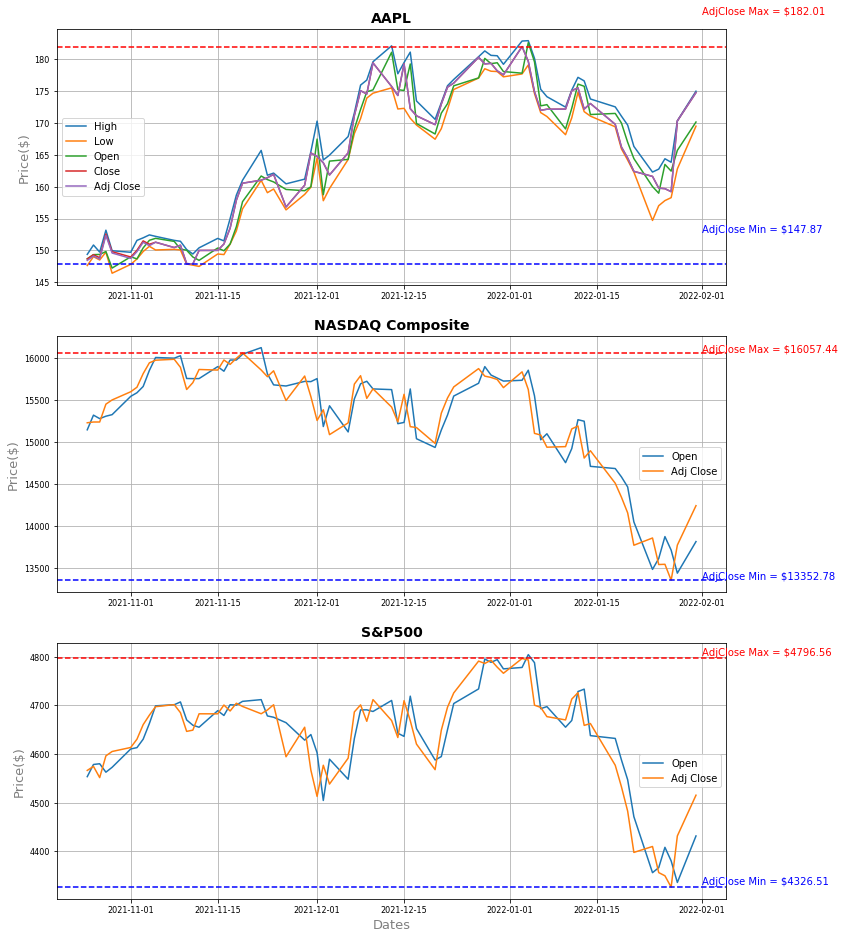

In [593]:
all_df = ticker_info()

## Forecasting with a Stacked-LSTM RNN Model
#### Predictors
* *Open*
* *Min*
* *Max*
* *Adj Close*
* *Volume*
* *NASDAQ Adj Close*
* *News Sentiment Output (Positive/Negative)*

#### Target
* *Adj Close* of a Target Stock Item

#### Time Step
* Dependent on the length of the input time series 

In [594]:
#all_df.to_csv('./all_df.csv')
#all_df = pd.read_csv("all_df.csv", index_col = 0)
all_df = all_df[['High', 'Low', 'Open', 
                 'Close', 'Volume', 'Adj Close', 
                 'NASDAQ Close', 'sentiment_neutral', 'sentiment_positive']]

# Standardize input data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(all_df)

# train test split
train_size = int(len(scaled_df)*0.8)
test_size = len(scaled_df)-train_size
train_df, test_df = scaled_df[0:train_size], scaled_df[train_size:] 
print(len(scaled_df),"=",train_size," + ",test_size)

62 = 49  +  13


In [595]:
# assign X and Y based on time steps
def assign(data, timestep = None):
    X, y = [],[]
    
    if timestep == None:
        default_timestep = 10
        for i in range(len(data)-default_timestep-1):
            values_X = data[i:(i+default_timestep)]
            values_y = data[i+default_timestep,5]
            
            X.append(values_X)
            y.append(values_y)
        
    else:
        for i in range(len(data)-timestep-1):  
            values_X = data[i:(i+timestep)]
            values_y = data[i+timestep,5]
            
            X.append(values_X)
            y.append(values_y)
    
    return np.array(X), np.array(y)


In [596]:
timestep=5

X_train, y_train = assign(train_df, timestep)
X_test, y_test = assign(test_df, timestep)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43, 5, 9) (43, 1)
(7, 5, 9) (7, 1)


In [599]:
# LSTM Params
# Activation: tanh
# Recurrent Activation: sigmoid
# Dropout: 0
# Output D: 50

# Output Dense Params
# Activation: Linear
# Output D: 1
config = {'loss':'mean_squared_error',
          'optimizer':'adam', 
          'epoch':5,
          'batch_size':8, 
          'metric':'mse',
          'verbose':1}

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(y_train.shape[1]))

model.compile(loss = config['loss'], 
              optimizer = config['optimizer'],
              metrics=[config['metric']])
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 5, 50)             12000     
                                                                 
 lstm_193 (LSTM)             (None, 5, 50)             20200     
                                                                 
 lstm_194 (LSTM)             (None, 50)                20200     
                                                                 
 dense_64 (Dense)            (None, 1)                 51        
                                                                 
Total params: 52,451
Trainable params: 52,451
Non-trainable params: 0
_________________________________________________________________


In [598]:
# customized callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.metric.append(logs.get(config['metric']))
        self.val_metric.append(logs.get('val_'+config['metric']))
        self.i += 1
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        fig.set_size_inches(10.5, 7.5)
        fig.suptitle('Processing',size = 20)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Train Loss")
        ax1.plot(self.x, self.val_losses, label="Valid Loss")
        ax1.legend()
        
        
        ax2.plot(self.x, self.metric, label="Train_"+config['metric'])
        ax2.plot(self.x, self.val_metric, label="Valid_"+config['metric'])
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

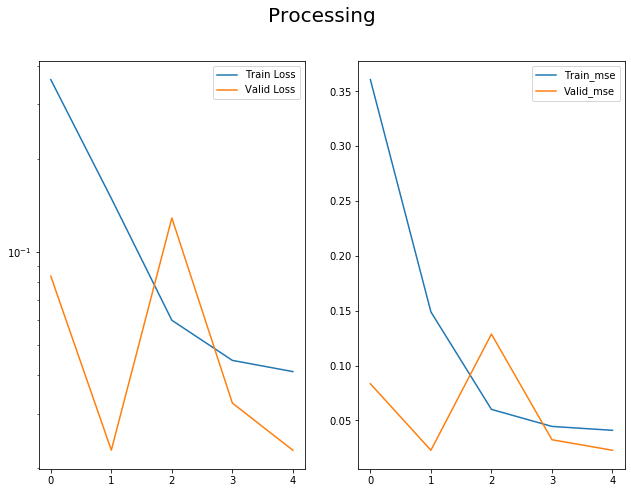

6/6 [==============================] - 0s 63ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0228 - val_mse: 0.0228


In [600]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=config["epoch"], 
                    batch_size=config["batch_size"],
                    verbose=config['verbose'],
                    callbacks=[plot])

## Evaluation

In [601]:
# Predict train & test sets
train_pred = model.predict(X_train)
train_pred_copies = np.repeat(train_pred, train_df.shape[1], axis=1) # Adjust the shape of the output
train_pred_inverse = scaler.inverse_transform(train_pred_copies)[:,0] # Scale back the normalized output

y_train_copies = np.repeat(y_train, train_df.shape[1], axis=1) # Adjust the shape of the output
y_train_inverse = scaler.inverse_transform(y_train_copies)[:,0] # Scale back the normalized output

test_pred = model.predict(X_test)
test_pred_copies = np.repeat(test_pred, test_df.shape[1], axis=1) # Adjust the shape of the output
test_pred_inverse = scaler.inverse_transform(test_pred_copies)[:,0] # Scale back the normalized output

y_test_copies = np.repeat(y_test, test_df.shape[1], axis=1) # Adjust the shape of the output
y_test_inverse = scaler.inverse_transform(y_test_copies)[:,0] # Scale back the normalized output

In [602]:
# Root Mean Squared Error for train & test sets
rmse_train = math.sqrt(mean_squared_error(y_train_inverse, train_pred_inverse))
rmse_test = math.sqrt(mean_squared_error(y_test_inverse, test_pred_inverse))
print('RMSE for train: %0.2f' % rmse_train)
print('RMSE for test: %0.2f' % rmse_test)

# Mean Absolute Percentage Error
mape_train = math.sqrt(mean_absolute_percentage_error(y_train_inverse, train_pred_inverse))
mape_test = math.sqrt(mean_absolute_percentage_error(y_test_inverse, test_pred_inverse))
print('MAPE for train: %0.2f' % mape_train)
print('MAPE for test: %0.2f' % mape_test)

RMSE for train: 6.73
RMSE for test: 5.06
MAPE for train: 0.18
MAPE for test: 0.17


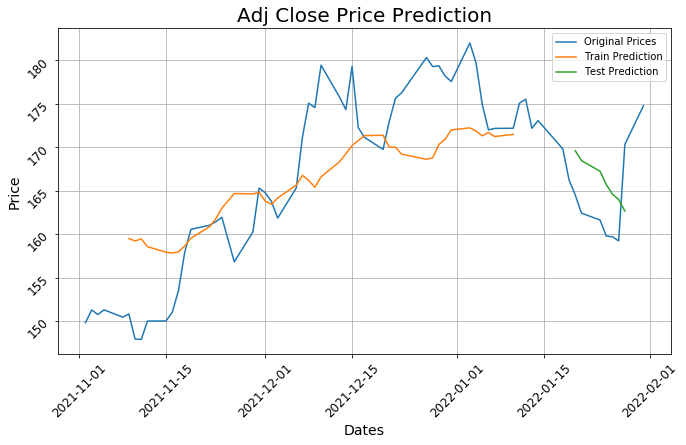

In [603]:
# create an array for train prediction values
timesteps = 5
train_prediction_array = np.empty_like(scaled_df[:,5])
train_prediction_array[:,] = np.nan
train_prediction_array[timesteps : len(train_pred_inverse)+timesteps, ] = train_pred_inverse

# create an array for test prediction values
test_prediction_array = np.empty_like(scaled_df[:,5])
test_prediction_array[:,] = np.nan
test_prediction_array[len(y_train)+(timesteps*2)+1 : len(scaled_df)-1, ] = test_pred_inverse

# original adj close price
orig_price = scaler.inverse_transform(scaled_df)[:, 5]

# plot baseline and predictions
plt.figure(figsize=(11,6))

plt.xticks(rotation=45, size=12)
plt.yticks(rotation=45, size=12)

plt.xlabel('Dates', size = 14)
plt.ylabel('Price', size = 14)
plt.title('Adj Close Price Prediction', size=20)

plt.plot(all_df.index, orig_price, label = "Original Prices")
plt.plot(all_df.index, train_prediction_array, label = "Train Prediction")
plt.plot(all_df.index, test_prediction_array, label = "Test Prediction")

plt.grid(True)
plt.legend()
plt.show()